# Neal's Funnel Target Practice

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [3]:
d = 1000
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

DynamicPPL.Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [1.0111148965017045, 0.9851691671285447, -1.1111746028847782, 1.0031028322007052, 2.09254014469917, -1.600592411056759, 1.4030016574407795, -1.174184135812221, -2.189283901328225, -1.6250702438509705, -0.36896963396311067, -0.34618249027317605, 0.556807074788708, 1.6040226062045997, 0.9504964528118238, 0.8638184368591666, -1.02336587726038, 0.46333920396815736, -1.7212601812489463, -0.1728272470420242, 2.3168957028673045, -2.506787005407861, 0.155446630276741, 0.16966393114907197, -0.6995897787634755, 0.5405449572562886, 0.8798635349364927, 3.2745879475148634, -1.1003143238005402, -1.9028175061617392, 1.5996013735445613, -0.016885201356868662, 0.4677703004729242, 1.9340386585026161, -1.4669085371671868, -0.25991500405705736, -1.1260471244722865, 0.38068359315496897, 0.5

## MCHMC

In [15]:
funnel_target = NealFunnelTarget(funnel_model; d=d, compute_MAP=false)
funnel_target.d = d
eps = 0.45
funnel_spl = MCHMC(eps, 57; init_eps=0.5, varE_wanted=1.0^-4, sigma=ones(d));

In [16]:
funnel_samples_mchmc = Sample(funnel_spl, funnel_target, 20_000;
                        dialog=true);

[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅


In [17]:
theta_mchmc = [sample[1] for sample in funnel_samples_mchmc]
x10_mchmc = [sample[10+1] for sample in funnel_samples_mchmc];

In [18]:
energy_mchmc = [sample[end-1] for sample in funnel_samples_mchmc]

20001-element Vector{Float64}:
  0.0
 -0.03113144097164877
 -0.019508901556150704
 -0.0061433972881559384
  0.0003252135455795724
 -0.0014040287406942298
 -0.005694354560091597
 -0.004842253388574136
  0.005232944836620845
  0.021114693863296452
  0.032355950788769405
  0.028432281515847535
  0.008912967068226862
  ⋮
 -0.042821478129553725
 -0.07165609306684928
 -0.07028760986077032
 -0.043668176528626645
 -0.0076322036311466945
  0.022246490525958507
  0.03693733162117496
  0.03478224062610025
  0.01864621655204246
 -0.005902388608774345
 -0.03223478348854769
 -0.053038168105558725

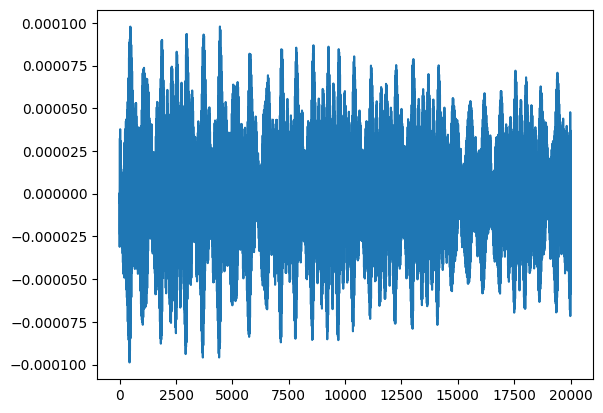

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f36353e2c10>

In [19]:
plot(energy_mchmc/d)

In [28]:
std(energy_mchmc)^2/d

9.513644883090074e-7

In [20]:
using MCMCDiagnosticTools

In [21]:
_samples = zeros(length(funnel_samples_mchmc), length(funnel_samples_mchmc[1]), 1)
_samples[:, :, 1] = mapreduce(permutedims, vcat, funnel_samples_mchmc)
_samples = permutedims(_samples, (1,3,2))
ess, rhat = MCMCDiagnosticTools.ess_rhat(_samples)

([95.76268368487877, 192.00972580735387, 128.6861090679284, 169.9991754741204, 179.87575522464815, 165.31186425839743, 145.63400553354046, 119.07813361369577, 136.76933638453835, 174.88397697188034  …  148.6285257444828, 163.5425347043712, 110.1648093324131, 186.88067518803564, 152.6338923413934, 198.6610677355942, 157.20506612897398, 183.98891798706515, 6785.607651295998, 113.06350320929029], [1.003551724617476, 1.000294458577312, 0.9999554711006958, 1.0002596251731195, 1.0005099193275735, 1.0000984146033487, 1.0001587360119961, 0.9999544591958207, 1.0001544877701152, 0.9999669880057115  …  0.9999545411942699, 1.0012601525801035, 1.0001198882993327, 1.000007287350482, 1.0000532614376985, 1.00037511658833, 1.0000350555128876, 1.000003890793736, 0.9999511290080224, 1.003862807078029])

In [22]:
_ess = median(ess)

178.15415940611615

In [23]:
_rhat = median(rhat)

1.0001596963317783

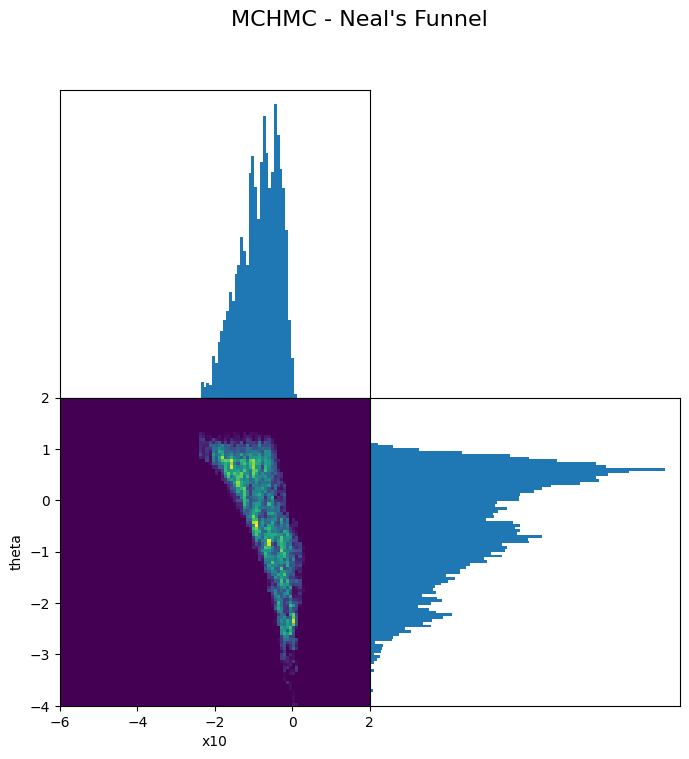

In [24]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("MCHMC - Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

## NUTS

In [ ]:
funnel_samples_hmc = sample(funnel_model, NUTS(10, 0.95), 10_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.2
Sampling:   3%|█▍                                       |  ETA: 2:25:49

In [ ]:
theta_hmc = [funnel_samples_hmc.value.data[i, 1, :][1] for i in axes(funnel_samples_hmc.value.data)[1]]
x10_hmc = [funnel_samples_hmc.value.data[i, 10+1, :][1] for i in axes(funnel_samples_hmc.value.data)[1]];

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("NUTS - Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_hmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_hmc, theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Comparison - Neal's Funnel", fontsize=16)
fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].hist(x10_hmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].hist(theta_hmc, bins=100, orientation="horizontal", range=[-4,2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");